# Part 1.1: Foundations of Reinforcement Learning

Welcome to the first notebook in our Reinforcement Learning tutorial series! This notebook introduces the fundamental concepts that make RL unique.

## What This Notebook Covers

- What makes Reinforcement Learning different from other ML paradigms
- The reward hypothesis and sequential decision making
- The agent-environment interaction loop
- States and the Markov property
- Fully observable vs partially observable environments

## What This Notebook Does NOT Cover

| Topic | Why Not Here | How It Differs From What We Cover |
|-------|--------------|-----------------------------------|
| **Specific RL algorithms** | This notebook focuses on concepts, not methods. Algorithms are covered in later notebooks once you understand the foundations. | We explain *what* RL is trying to achieve (maximize reward, find good policies). Algorithms like Q-learning, SARSA, and Policy Gradient are *how* to achieve it — they require understanding value functions and policies first. |
| **Deep reinforcement learning** | Deep RL combines RL with neural networks, adding significant complexity. We start with tabular methods where states are discrete and enumerable. | In this notebook, states are simple integers (0-15 in FrozenLake). Deep RL handles high-dimensional states like images or continuous values, using neural networks to approximate value functions — a topic that builds on everything here. |
| **Multi-agent RL** | Multi-agent settings introduce game theory, coordination, and competition. We focus on single-agent foundations first. | Here, one agent interacts with a passive environment. In multi-agent RL, multiple agents interact simultaneously, and one agent's optimal action depends on what others do — fundamentally changing the problem structure. |

## Prerequisites

- Basic Python programming
- Familiarity with NumPy and Matplotlib
- Basic probability concepts (expected value, probability distributions)

## How to Read This Notebook

1. **Theory first**: Each section starts with conceptual explanations
2. **Intuition building**: We use the FrozenLake environment as a concrete example throughout
3. **Code demonstrations**: Run the code cells to see concepts in action
4. **Checkpoints**: Use these to verify your understanding before moving on

Let's begin!

---
## Setup

First, let's import the necessary libraries and set up our environment.

> **Note:** If you're running this in a fresh environment (like Google Colab or a new virtualenv), uncomment and run the installation cell below first.

In [1]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


---

# 1. What is Reinforcement Learning?

Reinforcement Learning is a type of machine learning where an **agent** learns to make decisions by interacting with an **environment**. Unlike supervised learning (where we have labeled data) or unsupervised learning (where we find patterns in data), RL learns from **trial and error**.

## Key Characteristics of RL

RL has several unique characteristics that distinguish it from other machine learning paradigms:

| Characteristic | Description | FrozenLake Example |
|---------------|-------------|---------------------|
| **No supervisor** | There's no teacher telling the agent what the correct action is. Instead, there's only a reward signal indicating how good or bad an action was. | The agent isn't told "go RIGHT here" or "avoid this path." It only receives +1 for reaching the Goal and 0 otherwise. It must discover the correct path through trial and error. |
| **Delayed feedback** | The reward may come much later after the action was taken. A chess move might only prove good or bad many moves later. | The agent receives reward only at the end of an episode (reaching Goal or falling into a Hole). All intermediate moves on frozen tiles give 0 reward, so the agent doesn't know if early moves were good until much later. |
| **Sequential data** | Data is not i.i.d. (independent and identically distributed). Current observations depend on previous actions. | The state the agent sees depends entirely on its previous actions. Being in state 6 means the agent took a specific sequence of moves from the start. Each observation is a direct consequence of prior decisions. |
| **Actions affect future** | The agent's actions influence the data it will receive in the future. This creates a feedback loop. | Moving DOWN from state 0 leads to states 4 or below, while moving RIGHT leads to states 1 or to the right. The agent's choice determines which parts of the grid it will experience and whether it encounters Holes or the Goal. |

Supervised learning trains models on labeled data where inputs are paired with correct outputs, learning to predict labels for new inputs (e.g., classification, regression). Unsupervised learning finds patterns in unlabeled data without predefined outputs, discovering hidden structures like clusters or dimensionality reduction.

> **Checkpoint — You should now understand:**
> - Why RL is different from supervised and unsupervised learning
> - The four key characteristics that make RL unique
> - How these characteristics apply to the FrozenLake environment

---

# 2. The Agent-Environment Interface

In RL, we have two main entities:

1. **Agent**: The learner and decision maker
2. **Environment**: Everything outside the agent that it interacts with

## The Interaction Loop

At each time step $t$:

**Agent:**
- Receives observation $O_t$
- Receives reward $R_t$
- Executes action $A_t$

**Environment:**
- Receives action $A_t$
- Emits observation $O_{t+1}$
- Emits reward $R_{t+1}$

```
    ┌────────────────────────────────────────┐
    │                                        │
    │    ┌───────┐         ┌─────────────┐   │
    │    │       │  Action │             │   │
    │    │ Agent │────────►│ Environment │   │
    │    │       │         │             │   │
    │    └───────┘◄────────└─────────────┘   │
    │        ▲    Observation, Reward        │
    │        │                               │
    └────────┼───────────────────────────────┘
             │
         Time step t
```

## The History

The **history** $H_t$ is the sequence of all observations, actions, and rewards up to time $t$:

$$H_t = O_1, R_1, A_1, O_2, R_2, A_2, \ldots, A_{t-1}, O_t, R_t$$

**Plain English:** "The history at time t equals the sequence of the first observation, first reward, first action, second observation, second reward, second action, and so on, up to the action at time t-1, followed by the observation and reward at time t."

<details>
<summary>Formula components</summary>

- $H_t$ = the history (complete sequence of events) up to time step $t$
- $O_1$ = the first observation received
- $R_1$ = the first reward received
- $A_1$ = the first action taken
- $O_2$ = the second observation received
- $R_2$ = the second reward received
- $A_2$ = the second action taken
- $\ldots$ = the pattern continues
- $A_{t-1}$ = the action taken at time step $t-1$
- $O_t$ = the observation at current time step $t$
- $R_t$ = the reward at current time step $t$

</details>

This is everything that has happened. The next action (by the agent) and the next observation/reward (by the environment) depend on this history.

## Let's See This in Action: FrozenLake Environment

We'll use the **FrozenLake** environment from Gymnasium. This is a simple grid world where:

- **S** (Start): Starting position
- **F** (Frozen): Safe frozen surface (you can walk on it)
- **H** (Hole): Hole in the ice (falling in ends the episode with 0 reward)
- **G** (Goal): The goal (reaching it gives reward of 1)

The agent can take 4 actions:
- 0: LEFT
- 1: DOWN
- 2: RIGHT
- 3: UP

> **Note**: The ice is slippery! When the agent chooses an action, it only moves in that direction 1/3 of the time. The other 2/3 of the time, it slips perpendicular to the intended direction.

In [3]:
# Create the FrozenLake environment
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)

# Reset the environment to get the initial observation
observation, info = env.reset(seed=42)

print("FrozenLake Environment")
print("=" * 40)
print(f"\nState space: {env.observation_space}")
print(f"Number of states: {env.observation_space.n}")
print(f"\nAction space: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")
print(f"\nInitial observation (state): {observation}")

FrozenLake Environment

State space: Discrete(16)
Number of states: 16

Action space: Discrete(4)
Number of actions: 4

Initial observation (state): 0


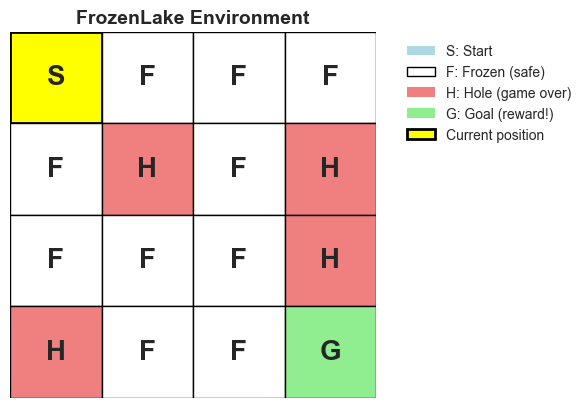

In [4]:
# Helper function to visualize the FrozenLake grid
def visualize_frozenlake(env, current_state=None, title="FrozenLake Environment"):
    """Visualize the FrozenLake grid with the current state highlighted."""
    # Get the map
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    # Create figure
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Color mapping
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    # Draw the grid
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            color = colors.get(cell, 'white')
            
            # Highlight current state
            state_idx = i * ncol + j
            if current_state is not None and state_idx == current_state:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True, 
                                     facecolor='yellow', edgecolor='black', linewidth=2)
            else:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            
            # Add text
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                   ha='center', va='center', fontsize=20, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='F: Frozen (safe)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='H: Hole (game over)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (reward!)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', linewidth=2, label='Current position')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    return fig, ax

# Visualize the environment
visualize_frozenlake(env, current_state=observation)
plt.show()

## The Agent-Environment Interaction in Code

Let's see how the agent interacts with the environment step by step.

> **Note on Episode Endings:** In Gymnasium, an episode can end in two ways:
> - **Terminated**: The agent reached a terminal state (Goal or Hole). The task is "naturally" over.
> - **Truncated**: The episode was cut short by a time limit (e.g., taking too many steps without reaching the goal). This prevents the agent from wandering forever.
>
> The old Gym API used a single `done` flag, but the new Gymnasium API separates these cases because they have different implications for learning (truncated episodes might still have future value, while terminated episodes don't).

In [5]:
# Reset the environment
observation, info = env.reset(seed=42)

print("Step-by-Step Agent-Environment Interaction")
print("=" * 50)
print(f"\nInitial state: {observation}")

# Action names for better readability
action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}

# Helper function to compute expected next state (for slip detection)
def get_expected_state(state, action, nrow=4, ncol=4):
    """Calculate where the agent would go if no slip occurred."""
    row, col = state // ncol, state % ncol
    if action == 0:  # LEFT
        col = max(col - 1, 0)
    elif action == 1:  # DOWN
        row = min(row + 1, nrow - 1)
    elif action == 2:  # RIGHT
        col = min(col + 1, ncol - 1)
    elif action == 3:  # UP
        row = max(row - 1, 0)
    return row * ncol + col

# Let's take a few actions and observe the interaction
history = [(observation, None, None)]  # (state, action, reward)

for step in range(5):
    # Agent chooses a random action
    action = env.action_space.sample()
    
    # Environment responds with new observation, reward, and other info
    new_observation, reward, terminated, truncated, info = env.step(action)
    
    history.append((new_observation, action, reward))
    
    # Check if the agent slipped
    expected_state = get_expected_state(observation, action)
    slipped = (new_observation != expected_state)
    slip_msg = " (Slipped!)" if slipped else ""
    
    print(f"\n--- Step {step + 1} ---")
    print(f"  State: {observation}")
    print(f"  Action taken: {action} ({action_names[action]})")
    print(f"  Expected state: {expected_state}")
    print(f"  New state: {new_observation}{slip_msg}")
    print(f"  Reward received: {reward}")
    print(f"  Episode over: {terminated or truncated}")
    
    observation = new_observation
    
    if terminated or truncated:
        print("\n*** Episode ended! ***")
        break

env.close()

Step-by-Step Agent-Environment Interaction

Initial state: 0

--- Step 1 ---
  State: 0
  Action taken: 0 (LEFT)
  Expected state: 0
  New state: 0
  Reward received: 0
  Episode over: False

--- Step 2 ---
  State: 0
  Action taken: 2 (RIGHT)
  Expected state: 1
  New state: 0 (Slipped!)
  Reward received: 0
  Episode over: False

--- Step 3 ---
  State: 0
  Action taken: 0 (LEFT)
  Expected state: 0
  New state: 4 (Slipped!)
  Reward received: 0
  Episode over: False

--- Step 4 ---
  State: 4
  Action taken: 2 (RIGHT)
  Expected state: 5
  New state: 8 (Slipped!)
  Reward received: 0
  Episode over: False

--- Step 5 ---
  State: 8
  Action taken: 2 (RIGHT)
  Expected state: 9
  New state: 4 (Slipped!)
  Reward received: 0
  Episode over: False


In [6]:
# Visualize the history
print("\nHistory of the episode:")
print("H_t = ", end="")
for i, (state, action, reward) in enumerate(history):
    if action is None:
        print(f"S{state}", end="")
    else:
        print(f" → A{action}({action_names[action]}) → R{reward}, S{state}", end="")
print()


History of the episode:
H_t = S0 → A0(LEFT) → R0, S0 → A2(RIGHT) → R0, S0 → A0(LEFT) → R0, S4 → A2(RIGHT) → R0, S8 → A2(RIGHT) → R0, S4


> **Checkpoint — You should now understand:**
> - The agent-environment interaction loop (observe → act → receive reward → repeat)
> - How the history captures everything that has happened
> - How to interact with the Gymnasium API

---

# 3. The Reward Signal

The **reward** $R_t$ is a scalar feedback signal that indicates how well the agent is doing at time step $t$.

The agent's goal is to **maximize the cumulative reward** over time.

$$\text{Goal: Maximize } \sum_{t=0}^{\infty} R_t$$

**Plain English:** "The goal is to maximize the sum of all rewards from time 0 to infinity."

<details>

<summary>Formula components</summary>

- $\text{Maximize}$ = find the maximum value of (the objective)
- $\sum_{t=0}^{\infty}$ = the sum from time step $t$ equals 0 to infinity
- $R_t$ = the reward at time step $t$

</details>

## The Reward Signal in FrozenLake

In the FrozenLake environment, the reward structure is simple but instructive:

| Event | Reward | Meaning |
|-------|--------|--------|
| Step on Frozen tile (F) | 0 | No immediate feedback - the agent doesn't know if it's on the right path |
| Fall into Hole (H) | 0 | Episode ends with no reward - the agent failed |
| Reach Goal (G) | +1 | Episode ends successfully - this is the only positive signal |

This **sparse reward** structure makes learning challenging:
- The agent receives the same reward (0) for safe moves and falling into holes
- Only reaching the Goal provides a positive signal
- The agent must learn to associate earlier actions with the eventual outcome

## How Can the Agent Maximize Reward in FrozenLake?

Since the only positive reward (+1) comes from reaching the Goal, the agent maximizes cumulative reward by:

1. **Finding paths that lead to the Goal** - The agent must discover which sequences of actions successfully navigate from S to G

2. **Avoiding Holes** - Falling into a Hole ends the episode with 0 total reward, so the agent must learn to steer away from H tiles

3. **Handling the slippery ice** - Since the ice is slippery, the intended action only succeeds 1/3 of the time. The other 2/3 of the time, the agent slips perpendicular to the intended direction. The agent must learn policies that are robust to this stochasticity (e.g., staying away from Holes even when "pushed" by the slippery ice)

## The Reward Hypothesis

> **"All goals can be described as the maximization of expected cumulative reward."**

This is a foundational assumption in RL. While powerful, it's also debated:

**Arguments for:**
- Many complex behaviors can indeed be expressed as reward maximization
- It provides a unified framework for decision-making

**Arguments against:**
- Some goals (curiosity, creativity, ethics) are hard to quantify as a single scalar
- Designing the right reward function (reward shaping) is often very challenging

> **Checkpoint — You should now understand:**
> - What the reward signal is and how it guides learning
> - Why FrozenLake's sparse reward structure makes learning challenging
> - The reward hypothesis and its implications

---

# 4. Sequential Decision Making

The goal of sequential decision making is to select actions that **maximize total future reward**.

> **Key insight:** Actions may have **long-term consequences**, and rewards may be **delayed**. Sometimes it's better to sacrifice immediate reward for greater long-term gain.

### Examples:

1. **Financial investment**: You invest money today (losing immediate spending power) for returns months or years later.

2. **Helicopter refueling**: Refueling now (taking time away from the mission) prevents crashes hours later.

3. **Chess**: Sacrificing a piece now might lead to checkmate many moves later.

4. **Education**: Studying hard now (foregoing leisure) leads to better career opportunities later.

## Sequential Decision Making in FrozenLake

FrozenLake is a perfect example of sequential decision making. Let's break down why:

### Why is it Sequential?

Each decision depends on where you are, and where you are depends on all previous decisions:

```
Step 1: At S (state 0) → Choose DOWN → Move to state 4
Step 2: At state 4 → Choose DOWN → Move to state 8
Step 3: At state 8 → Choose RIGHT → Move to state 9
...and so on until reaching G or falling into H
```

The agent cannot jump directly to the Goal - it must navigate through a **sequence of states**, and each action opens or closes future possibilities.

### Trade-offs in FrozenLake

| Sacrifice | Short-term Cost | Long-term Benefit |
|-----------|-----------------|-------------------|
| **Taking a longer path** | More steps | Avoids Holes, higher probability of reaching Goal |
| **Moving away from Goal temporarily** | Increases distance to reward | May avoid a dangerous Hole in the direct path |
| **Staying near edges** | Limits movement options | Reduces risk of slipping into Holes |

### A Concrete Example: The Greedy Trap

```
Grid layout (4x4)       States
S  F  F  F              0  1  2  3
F  H  F  H              4  5  6  7
F  F  F  H              8  9  10 11
H  F  F  G              12 13 14 15
```

**Greedy approach** (always move toward Goal):
- From state 0: Go RIGHT and DOWN as directly as possible toward state 15 (0→1→5→10→11→15)
- Problem: This path goes through states 5 and 11 - those are Holes!

**Sequential thinking approach**:
- From state 0: Go DOWN first (states 0→4→8), then navigate around Holes
- The path S→4→8→9→10→14→15 avoids all Holes
- Even though going DOWN initially moves "sideways" relative to the Goal, it's the winning strategy

### The Key Insight

In FrozenLake, the agent must learn that:
- **Immediate progress toward the Goal can be fatal** (Holes block direct paths)
- **Seemingly suboptimal moves may be necessary** (going around Holes)
- **The slippery ice adds uncertainty** - even "safe" moves might slip into danger (recall that intended actions only succeed 1/3 of the time)
- **Every decision shapes future options** - one wrong move can make the Goal unreachable

This is the essence of sequential decision making: **optimize for the cumulative outcome, not each individual step**.

> **Checkpoint — You should now understand:**
> - Why actions have long-term consequences
> - The difference between greedy and strategic decision making
> - Why the "obvious" path in FrozenLake is often wrong

---

# 5. State and the Markov Property

## What is State?

The **state** is the information used to determine what happens next. Formally, the state is a function of the history:

$$S_t = f(H_t)$$

**Plain English:** "The state at time t equals some function applied to the history at time t."

<details>

<summary>Formula components</summary>

- $S_t$ = the state at time step $t$
- $f$ = a function that processes the history
- $H_t$ = the history (complete sequence of observations, actions, and rewards) up to time $t$

</details>

In other words: the state is a **summary** of the history that captures all relevant information.


## Types of State

### 1. Environment State ($S_t^e$)
- The environment's **internal representation**
- Used by the environment to generate the next observation and reward
- Usually **not visible** to the agent
- May contain irrelevant information

### 2. Agent State ($S_t^a$)
- The agent's **internal representation**
- Used by the agent to select the next action
- Can be any function of the history: $S_t^a = f(H_t)$
- This is what RL algorithms use

## Understanding the Difference: Environment State vs Agent State in FrozenLake

Let's clarify these concepts with FrozenLake as a concrete example, because understanding the **conceptual difference** is important even when they contain the same information.

### Environment State ($S_t^e$) in FrozenLake

The **environment state** contains everything the environment needs to determine what happens next:

| Component | What It Contains | Example in FrozenLake |
|-----------|------------------|----------------------|
| **Agent position** | Current location on grid | State 10 (row 2, column 2) |
| **Grid layout** | Location of Start, Frozen, Holes, Goal | Fixed 4×4 grid with S, F, H, G tiles |
| **Transition dynamics** | How actions affect state transitions | 1/3 success rate, 2/3 perpendicular slip |
| **Reward function** | How rewards are generated | +1 for Goal, 0 otherwise |

**Key point:** The environment state is the "ground truth" - it contains the complete rules of the game. The environment uses this to compute the next state and reward when the agent takes an action.

### Agent State ($S_t^a$) in FrozenLake

The **agent state** is what the agent knows and uses to make decisions:

| What Agent Builds | Why | Example |
|-------------------|-----|---------|
| **Observation** | What the agent receives from environment | Current position (0-15) |
| **Memory** | Historical information the agent chooses to remember | Could track previous positions, action history, etc. |
| **Internal representation** | Any derived features or beliefs | Could compute distance to goal, proximity to holes, etc. |

**Key point:** The agent constructs its own state representation. It might use just the observation, or it might combine observations over time, or add derived features.

### Why Are They Conceptually Different?

Even though they contain the same information in simple environments like FrozenLake, they serve **different roles**:

1. **Purpose:**
   - **Environment state**: Used by the **environment** to generate next observation and reward
   - **Agent state**: Used by the **agent** to select next action

2. **Knowledge:**
   - **Environment state**: Contains "true" dynamics (transition probabilities, reward function)
   - **Agent state**: Contains what the agent knows or believes (may not know true dynamics)

3. **Control:**
   - **Environment state**: Fixed by the environment design
   - **Agent state**: Chosen by the agent/algorithm designer

4. **Perspective:**
   - **Environment state**: "God's eye view" - what actually exists
   - **Agent state**: "Agent's eye view" - what it can observe and remember


## The Markov Property

A state $S_t$ is **Markov** if and only if:

$$P[S_{t+1} | S_t] = P[S_{t+1} | S_1, S_2, \ldots, S_t]$$

**Plain English:** "The probability of the next state given only the current state equals the probability of the next state given the entire history of states."

<details>

<summary>Formula components</summary>

- $P[\cdot]$ = probability of the event in brackets
- $S_{t+1}$ = the state at the next time step
- $|$ = "given that" (conditional probability notation)
- $S_t$ = the current state at time step $t$
- $S_1, S_2, \ldots, S_t$ = the entire sequence of states from time 1 to time $t$

</details>

It means: **"The future is independent of the past, given the present."**

If a state is Markov:
- The state captures all relevant information from the history
- Once we know the current state, the history can be thrown away
- The state is a **sufficient statistic** of the future

### Examples:

**Markov:** In chess, the current board position is Markov. It doesn't matter how we got there - only the current position matters for determining the best move.

**Not Markov:** In poker with hidden cards, just knowing the visible cards isn't Markov - the history of betting might give information about hidden cards.

## Why is FrozenLake Markov?

FrozenLake is a perfect example of a Markov environment. Here's why:

### The State Contains All Relevant Information

In FrozenLake, the state is simply the agent's position (0-15). This single number tells us everything we need to know:

| What We Know from State | Why It's Sufficient |
|------------------------|---------------------|
| Current position on grid | Determines available actions and their outcomes |
| Distance to Goal | Implicit in position (state 15 is Goal) |
| Nearby Holes | Grid layout is fixed, so position reveals dangers |
| Possible next states | Transition probabilities depend only on current position |

### The History Doesn't Matter

Consider two different histories that both end in **state 10**:

```
History A: 0 → 4 → 8 → 9 → 10  (came from the left)
History B: 0 → 1 → 2 → 6 → 10  (came from above)
```

Once the agent is in state 10, the future is identical regardless of how it got there:
- Same actions available (LEFT, DOWN, RIGHT, UP)
- Same transition probabilities (1/3 chance each direction due to slippery ice)
- Same possible next states (6, 9, 11, 14)
- Same reward structure (0 for moves, +1 only at Goal)

**Key insight:** The path taken to reach state 10 provides **zero additional information** about what will happen next.

### Why This Matters

Because FrozenLake is Markov:
1. **Simple state representation** - We only need to track current position, not the entire history
2. **Efficient learning** - The agent can learn values for 16 states instead of infinitely many histories
3. **Optimal policies exist** - We can find a policy that maps states to actions without considering history
4. **Dynamic programming works** - Bellman equations (covered later) rely on the Markov property

FrozenLake as a Fully Observable MDP

The observation IS the state: 0
State type: int
Total number of states: 16

In FrozenLake:
- The agent knows exactly which cell it's in
- State = row * 4 + column (for 4x4 grid)
- Current state 0 means row 0, column 0


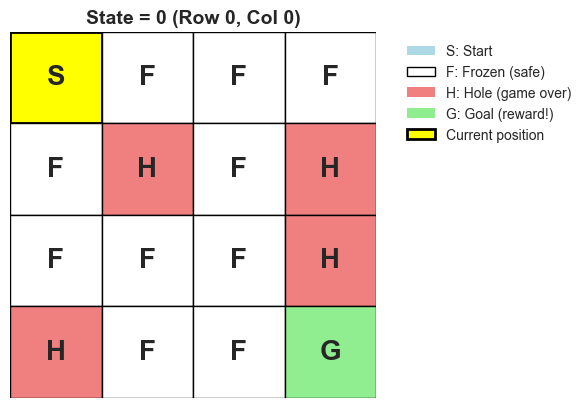

In [7]:
# Demonstrate FrozenLake as a Fully Observable MDP
env = gym.make("FrozenLake-v1", render_mode="rgb_array", is_slippery=True)
observation, info = env.reset(seed=42)

print("FrozenLake as a Fully Observable MDP")
print("=" * 50)
print(f"\nThe observation IS the state: {observation}")
print(f"State type: {type(observation).__name__}")
print(f"Total number of states: {env.observation_space.n}")
print("\nIn FrozenLake:")
print("- The agent knows exactly which cell it's in")
print("- State = row * 4 + column (for 4x4 grid)")
print(f"- Current state {observation} means row {observation // 4}, column {observation % 4}")

# Visualize
visualize_frozenlake(env, current_state=observation, title=f"State = {observation} (Row {observation // 4}, Col {observation % 4})")
plt.show()

env.close()

> **Checkpoint — You should now understand:**
> - What the Markov property means: "the future is independent of the past, given the present"
> - Why FrozenLake satisfies the Markov property
> - Why the Markov property makes RL problems tractable

## Fully Observable vs Partially Observable

### Fully Observable Environment

When the agent **directly observes** the environment state:

$$O_t = S_t^a = S_t^e$$

**Plain English:** "The observation at time t equals the agent state at time t, which equals the environment state at time t."

<details>

<summary>Formula components</summary>

- $O_t$ = the observation received by the agent at time step $t$
- $S_t^a$ = the agent state at time step $t$ (the superscript $a$ denotes "agent")
- $S_t^e$ = the environment state at time step $t$ (the superscript $e$ denotes "environment")

</details>

- Agent state = Environment state = Information state
- This is called a **Markov Decision Process (MDP)**
- Example: FrozenLake - the agent knows exactly which cell it's in


### Partially Observable Environment

When the agent only **indirectly observes** the environment:

$$O_t \neq S_t^e$$

**Plain English:** "The observation at time t does not equal the environment state at time t."

<details>

<summary>Formula components</summary>

- $O_t$ = the observation received by the agent at time step $t$
- $\neq$ = "does not equal" (not equal to)
- $S_t^e$ = the environment state at time step $t$

</details>

- Agent state ≠ Environment state
- This is called a **Partially Observable MDP (POMDP)**

### FrozenLake is Fully Observable

In standard FrozenLake, these states **align perfectly**:

$$O_t = S_t^a = S_t^e = \text{position (0-15)}$$

**Why?**
- The agent **directly observes** its exact position (no hidden information)
- The position alone determines everything about future transitions
- The grid layout is fixed and known to the agent
- The transition dynamics are fixed (though stochastic)

This makes FrozenLake a **Markov Decision Process (MDP)** - a fully observable environment where the agent has perfect information about the state.

> **Optional — Advanced Topic: POMDPs**
>
> In POMDPs, the agent cannot directly see the true state. Examples:
> - A robot with a camera doesn't know its exact position
> - A trading agent only sees current prices, not market sentiment
> - A poker player only sees public cards, not opponents' hands
>
> In POMDPs, the agent must build its own state representation, such as:
> - Complete history: $S_t^a = H_t$
> - Beliefs (probability distribution over possible states)
> - Recurrent neural network: $S_t^a = \sigma(S_{t-1}^a W_s + O_t W_o)$
>
> We won't cover POMDPs in detail in this tutorial series, but they're important for real-world applications.

### Counterexample: When They Would Differ

Imagine a modified FrozenLake where:
- **Tiles wear out**: Each tile can be stepped on only 3 times before breaking into a hole
- **Hidden information**: The agent doesn't see how many steps remain on each tile

Then:
- **Environment state** $S_t^e$: $(position, wear\_count\_0, wear\_count\_1, \ldots, wear\_count_{15})$
- **Observation** $O_t$: $position$ only
- **Agent state** $S_t^a$ (if using just observation): $position$
- **Agent state** $S_t^a$ (if using memory): $(position, history\_of\_visited\_tiles)$

The agent would need to **remember** where it's been to estimate which tiles are dangerous. This would be a **POMDP** (Partially Observable MDP), where $S_t^a \neq S_t^e$.

### Why This Matters

Understanding that environment state and agent state are conceptually different helps you:

1. **Recognize information asymmetry**: In many real-world problems, the agent doesn't have full information
2. **Design better representations**: The agent might need to remember history or maintain beliefs
3. **Choose appropriate algorithms**: 
   - MDPs (fully observable): Can use simpler algorithms
   - POMDPs (partially observable): Need more sophisticated methods
4. **Debug learning failures**: Sometimes the agent fails because its state representation is missing critical information

> **For FrozenLake:** Because it's fully observable, we can use simple tabular methods (Q-learning, SARSA) that assume the agent knows exactly where it is. This simplicity makes FrozenLake perfect for learning RL fundamentals!

> **Checkpoint — You should now understand:**
> - The difference between fully observable (MDP) and partially observable (POMDP) environments
> - Why FrozenLake is an MDP (agent knows exact state)

---

# 6. Summary and Concept Map

In this notebook, we covered the foundational concepts of Reinforcement Learning:


## Key Concepts

```
REINFORCEMENT LEARNING FOUNDATIONS
====================================

┌─────────────────────────────────────────────────────────┐
│                    THE BIG PICTURE                      │
│                                                         │
│   Agent ◄───────────────────────────► Environment       │
│      │         actions                    │             │
│      │                                    │             │
│      └────── observations, rewards ◄──────┘             │
│                                                         │
└─────────────────────────────────────────────────────────┘

KEY IDEAS:
──────────
1. RL = Learning from interaction (trial and error)
   └── No supervisor, only reward signals
   
2. The Agent-Environment Interface
   └── Agents observe, act, receive rewards
   └── History captures all past interactions
   
3. Sequential decision making
   └── Actions have long-term consequences
   └── Optimize cumulative reward, not immediate reward
   
4. The Markov property
   └── "The future depends only on the present"
   └── Current state contains all relevant information
   
5. MDP vs POMDP
   └── MDP: Agent sees true state (like FrozenLake)
   └── POMDP: Agent sees partial observations
```


## What's Next?

In the next notebook (**01_2_policies_and_exploration.ipynb**), we'll learn about:
- **Policies**: How agents decide which actions to take
- **Exploration vs Exploitation**: The fundamental RL dilemma
- **Prediction vs Control**: Two core problems in RL

*Later, we will formalize the intuition of "good states" using value functions, which assign a single number to each state capturing its long-term desirability.*

---

# 7. Your Turn

Now it's time to test your understanding with some exercises!


## Exercise 1: Conceptual Question

Consider a modified FrozenLake environment where:
- Each frozen tile (F) can only be stepped on 3 times before it breaks and becomes a hole
- The environment tracks how many times each tile has been visited

**Question:** Would this modified environment still satisfy the Markov property if we only observe the agent's position (0-15)? Why or why not?

*Think about your answer before looking at the hint below.*

<details>
<summary>Click to see hint</summary>

Think about what information would be missing if we only know the current position. Does the history of where we've been affect what happens next?

</details>

<details>
<summary>Click to see answer</summary>

**No, it would NOT be Markov with just the position.** 

In the modified environment, knowing only the current position isn't enough - we also need to know how many times each tile has been visited. Two agents at the same position might face different outcomes: one might be standing on a tile that's about to break, while the other is on a fresh tile.

To make it Markov, we'd need to expand the state to include visit counts for all tiles, e.g., `(position, visit_count_tile_0, visit_count_tile_1, ...)`.

</details>

## Exercise 2: Code Task

Modify the code below to run an episode and count:
1. How many times the agent slipped (moved in an unintended direction)
2. The total number of steps taken

Then calculate the "slip rate" (slips / total steps).

In [8]:
# YOUR CODE HERE
# Uncomment and complete the code below

# env = gym.make("FrozenLake-v1", is_slippery=True)
# observation, info = env.reset(seed=123)

# action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}
# slip_count = 0
# step_count = 0

# for _ in range(100):  # Max 100 steps
#     action = env.action_space.sample()
#     
#     # Calculate expected state (use the get_expected_state function from earlier)
#     expected = get_expected_state(observation, action)
#     
#     new_observation, reward, terminated, truncated, info = env.step(action)
#     
#     # TODO: Check if agent slipped and update slip_count
#     # TODO: Update step_count
#     
#     observation = new_observation
#     
#     if terminated or truncated:
#         break

# # Calculate and print the slip rate
# slip_rate = slip_count / step_count if step_count > 0 else 0
# print(f"Total steps: {step_count}")
# print(f"Total slips: {slip_count}")
# print(f"Slip rate: {slip_rate:.2%}")

# env.close()

> **Why this matters:** Understanding slip rates helps you appreciate why FrozenLake is challenging. In the next notebook, we'll see how different policies handle this stochasticity, and later you'll learn algorithms that explicitly account for uncertain transitions.

---

**Congratulations! You've completed Part 1.1 of the RL Tutorial!**

Key takeaways:
- RL agents learn from interaction with an environment
- The reward signal guides learning toward good behavior
- Sequential decisions require long-term thinking
- The Markov property simplifies RL problems significantly

Next: 01_2_policies_and_exploration.ipynb